In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class grid():
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.x_points = np.empty(0)
        self.y_points = np.empty(0)
        self.x_max = 1000
        self.y_max = 1000
        self.grid = {}  
        self.elevation = {}
        self.elevation_intermediate = []
        self.grid_customers = {}  
        self.n_customers = 0      
        self.customer_points = {}
        self.customer_points_intermediate = {}
        self.depot = None
        self.d_ij_indices = {} 
        self.n_intermediate = 0
        self.d_ij = None          # distances among customers - interface output for the optimization model
        self.d_ij_extended = None
        self.output_matrix = None
        self.output_matrix_extended = None
        self.tw_a = None
        self.tw_b = None
        self.load = None
        self.servicetime = 5 # minutes
        
        self.create_grid()
        self.grid_dict()
        
    def create_grid(self):
        delta_x = 20
        delta_y = 20
        np.random.seed(9)
        self.x_points = np.linspace(0, self.x_max, self.n_x+1) + np.random.randint(-delta_x, delta_x, self.n_x+1)
        self.y_points = np.linspace(0, self.y_max, self.n_y+1) + np.random.randint(-delta_y, delta_y, self.n_y+1)
        self.x_points[0] = 0; self.x_points[-1] = self.x_max
        self.y_points[0] = 0; self.y_points[-1] = self.y_max
        self.x_points.sort()
        self.y_points.sort()
        
    def grid_dict(self):
        for i in range(self.n_x+1):
            for j in range(self.n_y+1):
                self.grid[(i,j)] = (self.x_points[i], self.y_points[j])
                self.elevation[(i,j)] = 30*np.random.random()
        return self.grid
    
    def time_windows(self, tp='random', min_t=50, max_t=200, k_separation = 0.05, k_overlapped = 0.5):
        tw_a = np.zeros(1, dtype=int); tw_b = np.zeros(1, dtype=int)
        if tp == 'random':
            delta_lower = min_t/2
            delta_upper = delta_lower
            tw_center = np.random.randint(min_t+delta_lower, max_t-delta_upper, self.n_customers)
            self.tw_a = np.append(tw_a, tw_center - np.random.randint(0, delta_lower, self.n_customers))
            self.tw_b = np.append(tw_b, tw_center + np.random.randint(0, delta_upper, self.n_customers))
            return self.tw_a, self.tw_b
        if tp == 'separated':
            delta_tw = (max_t - min_t)/self.n_customers
            self.tw_a = np.append(tw_a, np.array([min_t + (i - k_separation)*delta_tw for i in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + (i + k_separation)*delta_tw for i in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
        if tp == 'overlapped':
            tw_c = (max_t - min_t)/2
            tw_interval = 0.5*k_overlapped*tw_c # half base interval (centered halfway between max_t and min_t)
            delta_interval = np.random.randint(0, tw_interval, self.n_customers)
            self.tw_a = np.append(tw_a, np.array([min_t + tw_c - t for t in sorted(delta_interval)]) )
            self.tw_b = np.append(tw_b, np.array([min_t + tw_c + t for t in sorted(delta_interval)]) )
            return self.tw_a, self.tw_b
        if tp == 'single':
            self.tw_a = np.append(tw_a, np.array([min_t for _ in range(self.n_customers)]) )
            self.tw_b = np.append(tw_b, np.array([max_t for _ in range(self.n_customers)]) )
            return self.tw_a, self.tw_b
    
    def payload(self, min_p=5, max_p=30):
        self.load = np.append(np.zeros(1), np.random.randint(min_p, max_p, self.n_customers))
    
    def plot_grid(self):
        for i in range(self.n_x+1):
            plt.plot([self.x_points[i], self.x_points[i]], [0, self.y_max], color='gray')
        for j in range(self.n_y+1):
            plt.plot([0, self.x_max], [self.y_points[j], self.y_points[j]], color='gray')
        plt.title("Grid")
        
    def customers(self, n_customers):
        self.n_customers = n_customers
        random.seed(9);
        x_c = random.sample([i for i in range(1, self.n_x+1)], n_customers)
        y_c = random.sample([i for i in range(1, self.n_y+1)], n_customers)
        customer_points = [elem for elem in zip(x_c, y_c)]
        self.customer_points = {k:self.grid[k] for k in zip(x_c, y_c)}
        return self.customer_points
        
    def plot_customer_points(self):
        k = list(self.customer_points.values())
        self.plot_grid()
        for i in range(self.n_customers):
            plt.scatter(k[i][0], k[i][1])
        plt.title("Customers grid points")
        
    def plot_customer_number(self):
        k = list(self.customer_points.keys())
        a=np.empty((self.n_x+1,self.n_y+1))
        for x in range(self.n_x+1):
            for y in range(self.n_y+1):
                a[x,y]=self.elevation[(x,y)]
        plt.imshow(a,alpha=0.3, cmap='gnuplot2_r', interpolation='bicubic',origin='lower') 
        count=0 
        for i in range(self.n_customers):
            count+=1
            plt.text(k[i][0], k[i][1], f"{count}", fontsize=12)
        plt.title("Elevation and customers")
        
    def customers_paths(self, depot):
        ## # depot must be an appropriate tuple of coordinate indices of the grid: ex (12, 15): (12th pos. on x - 15th pos. on y)
        self.depot = depot
        nodes = list(self.customer_points.keys())  # we work with grid indices instead of coordinates
        nodes.insert(0, depot)
        
        # we insert an intermediate point only if the two points are not on the same horizontal or vertical line 
        # a variation could be to use a point internal to the horizontal/vertical edge if the the latter is longer than 1 grid point
        self.n_intermediate = 0    
        for i in range(self.n_customers+1):
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                dy_index = nodes[i][1] - nodes[j][1]
                if (dx_index != 0 and dy_index != 0):
                    self.n_intermediate += 1
        self.n_intermediate //= 2
        
        self.d_ij = np.zeros((self.n_customers+1, self.n_customers+1))
        self.d_ij_extended = np.zeros((self.n_customers+1+self.n_intermediate, self.n_customers+1+self.n_intermediate))
        
        self.customer_points_intermediate = self.customer_points.copy()
        int_node = 0
        for i in range(self.n_customers+1):
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                dy_index = nodes[i][1] - nodes[j][1]
                node_int = (nodes[i][0] - dx_index, nodes[i][1])
                self.d_ij_indices[(i,j)] = (nodes[i], node_int, nodes[j])
                
                dx = abs(self.grid[node_int][0] - self.grid[nodes[i]][0])
                dy = abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                self.d_ij[i,j] = dx + dy
                self.d_ij_extended[i,j] = dx + dy 
                
                if (dx_index != 0 and dy_index != 0) and (self.grid[node_int][1] <= self.grid[nodes[j]][1]):
                    self.customer_points_intermediate[node_int] = self.grid[node_int]
                    int_node += 1
                    self.d_ij_extended[i,self.n_customers+int_node] = abs(self.grid[node_int][0] - self.grid[nodes[i]][0])   
                    self.d_ij_extended[self.n_customers+int_node,i] = self.d_ij_extended[i,self.n_customers+int_node]#abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                    self.d_ij_extended[j,self.n_customers+int_node] = abs(self.grid[node_int][1] - self.grid[nodes[j]][1])
                    self.d_ij_extended[self.n_customers+int_node,j] = self.d_ij_extended[j,self.n_customers+int_node]
                    self.elevation_intermediate.append(self.elevation[node_int])
                    
        
        return self.d_ij
    
    def create_csv(self):
        elevation = np.zeros(self.n_customers)
        # elevation_intermediate = np.zeros(self.n_customers+self.n_intermediate)
        
        for i, k in enumerate(self.customer_points.keys()):
            elevation[i] = self.elevation[k]
        # for i, k in enumerate(self.customer_points_intermediate.keys()):
        #     elevation_intermediate[i] = self.elevation[k]
         
        elevation = np.append(self.elevation[self.depot], elevation)
        elevation_intermediate = np.append(elevation, self.elevation_intermediate)
        
        service_time = np.append(np.zeros(1), np.array([self.servicetime for _ in range(self.n_customers)]) )
        service_time_intermediate = np.append(service_time, np.nan*np.ones(self.n_intermediate))
        
        x = np.append(self.grid[self.depot][0], np.array([v[0] for v in self.customer_points.values()]) )
        y = np.append(self.grid[self.depot][1], np.array([v[1] for v in self.customer_points.values()]) )
        x_intermediate = np.append(x, np.zeros(self.n_intermediate))
        y_intermediate = np.append(y, np.zeros(self.n_intermediate))
        
        index = np.linspace(0,self.n_customers,self.n_customers+1)
        index_intermediate = np.linspace(0,self.n_customers+self.n_intermediate,self.n_customers+self.n_intermediate+1)
        
        self.output_matrix = np.c_[index, x, y, elevation, self.load, self.tw_a, self.tw_b, service_time, self.d_ij/1000]
        
        load_intermediate = np.append(self.load.copy(), -np.ones(self.n_intermediate))
        tw_a_intermediate = np.append(self.tw_a.copy(), np.zeros(self.n_intermediate))
        tw_b_intermediate = np.append(self.tw_b.copy(), np.zeros(self.n_intermediate))
        service_time_intermediate = np.append(service_time.copy(), np.zeros(self.n_intermediate))
        self.output_matrix_extended = np.c_[index_intermediate, x_intermediate, y_intermediate, elevation_intermediate, load_intermediate, tw_a_intermediate, 
                                            tw_b_intermediate, service_time_intermediate, self.d_ij_extended/1000]
                                            
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1):
            header += ','+str(i)
           
        #np.savetxt('generated_grid_1.csv', self.output_matrix, delimiter=',', header=header, comments='')
        
        header = ',x,y,elevation,demand,tw a,tw b,s'
        for i in range(self.n_customers+1+self.n_intermediate):
            header += ','+str(i)
        
        np.savetxt('generated_grid_extended.csv', self.output_matrix_extended, delimiter=',', header=header, comments='')
                                            
        return self.output_matrix

## Grid definition
- example of $10\times 10$ synthetic grid.

In [3]:
G = grid(10, 10)
print(f"{G.grid[(1,3)] = }")
print(f"{G.grid[(5,3)] = }")

G.grid[(1,3)] = (102.0, 302.0)
G.grid[(5,3)] = (513.0, 302.0)


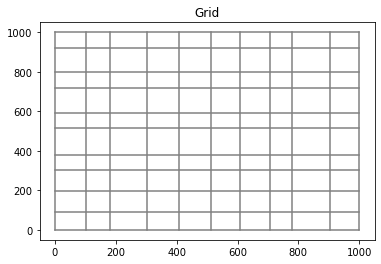

In [4]:
G.plot_grid()

### Insertion of custumers 

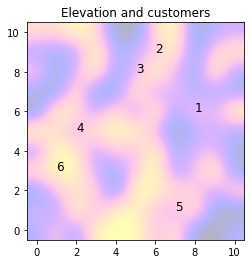

In [5]:
G.customers(n_customers=6)
G.plot_customer_number()

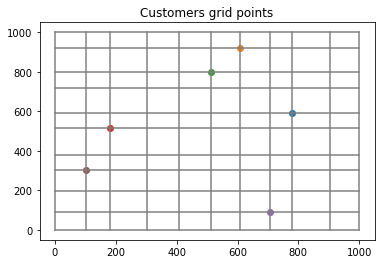

In [6]:
G.plot_customer_points()

In [7]:
print(G.elevation[(0,0)])
print(G.elevation[(3,5)])

22.950551869092376
10.627392858525313


### Definition of time windows and payload

In [8]:
ta,tb = G.time_windows(tp='single', min_t= 50, max_t=400)
print("Arrival min time:",ta)
print("Arrival max time:",tb)

Arrival min time: [ 0 50 50 50 50 50 50]
Arrival max time: [  0 400 400 400 400 400 400]


In [9]:
G.payload(min_p=5, max_p=30) 

### Example of base distance matrix 
**NB** extended distance matrix are better visualized as `.csv`

In [10]:
G.customers_paths((0,0))

array([[   0., 1371., 1527., 1312.,  696.,  800.,  404.],
       [1371.,    0.,  498.,  475.,  675.,  571.,  967.],
       [1527.,  498.,    0.,  215.,  831.,  925., 1123.],
       [1312.,  475.,  215.,    0.,  616.,  902.,  908.],
       [ 696.,  675.,  831.,  616.,    0.,  950.,  292.],
       [ 800.,  571.,  925.,  902.,  950.,    0.,  816.],
       [ 404.,  967., 1123.,  908.,  292.,  816.,    0.]])

In [11]:
 _  = G.create_csv()